# ReAct Agent

In this notebook we will build a [ReAct](https://react-lm.github.io/) agent, a general tool-calling agent architecture that:
- lets the model call specific tools
- passes the tool output back to the model
- lets the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

This [general purpose architecture](https://blog.langchain.dev/planning-for-agents/) can be applied to many types of tools. 

![ReAct architecture](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F06f2cf46-df40-48f9-a798-931222b0f70a_590x592.png)

The complete implementation of the ReAct agent can be found on `src/hackathon/agents/react/agent.py`

## Define LLM

In [1]:
from langchain_ollama import ChatOllama
from hackathon.config import OLLAMA_MODEL

llm = ChatOllama(model=OLLAMA_MODEL)

## Define State

In [2]:
from typing_extensions import TypedDict
from typing import Annotated, Any
from operator import add
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# define the state
class ReActState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]  # same as in langgraph.graph.MessagesState
    tool_outputs: Annotated[list[Any], add]
    

## Define Tools

Here we define the tools using the `@tool` decorator. We set `response_format="content_and_artifact"` to save the artifacts of a tool's execution that we want to make accessible to downstream components of the graph or backend APIs. "For example if a tool returns a custom object, a dataframe or an image, we may want to pass some metadata about this output to the model without passing the actual output to the model. At the same time, we may want to be able to access this full output elsewhere, for example in downstream tools." ([see docs](https://python.langchain.com/docs/how_to/tool_artifacts/))

This way, we distinguish between the parts of the tool output meant for the model (this is the ToolMessage.content) and those parts which are meant for use outside the model (ToolMessage.artifact).

In [7]:
from langchain_core.tools import tool

@tool(response_format="content_and_artifact", parse_docstring=True)
def add(a: int, b: int) -> tuple[str, int]:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    result = a + b
    message = f"Adding {a} and {b} gives {result}"
    return message, result

@tool(response_format="content_and_artifact", parse_docstring=True)
def multiply(a: int, b: int) -> tuple[str, int]:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    result = a * b
    message = f"Multiplying {a} and {b} gives {result}"
    return message, result

@tool(response_format="content_and_artifact", parse_docstring=True)
def divide(a: int, b: int) -> tuple[str, float]:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    if b == 0:
        raise ValueError("Cannot divide by zero")
    result = a / b
    message = f"Dividing {a} by {b} gives {result}"
    return message, result

tools = [add, multiply, divide]

# Bind tools to the LLM
llm_with_tools = llm.bind_tools(tools)

## Define ReAct agent

### Nodes

[`ToolNode`](https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.tool_node.ToolNode) is a useful shortcut if you want to create a node to execute tools.

The `ToolNode` is roughly analogous to:

```python
tools_by_name = {tool.name: tool for tool in tools}
def tool_node(state: dict):
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}
```

the [`tools_condition`](https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.tool_node.tools_condition) is a simple router used to build the ReAct's conditional edge:
- If the latest message from assistant is a tool call -> tools_condition routes to `"tools"` (we need to make sure to name the tool node as `"tools"`)
- If the latest message from assistant is a not a tool call -> tools_condition routes to `END`

### Graph

In [8]:
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Nodes
def llm_node(state: ReActState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

tool_node = ToolNode(tools)

# Graph
react_builder = StateGraph(ReActState)

# Define nodes
react_builder.add_node("llm", llm_node)
react_builder.add_node("tools", tool_node)

# Define edges
react_builder.add_edge(START, "llm")
react_builder.add_conditional_edges("llm", tools_condition)  # routes to "tools" or "__end__"
react_builder.add_edge("tools", "llm")

# Compile the graph
react_graph = react_builder.compile()

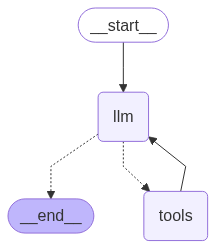

In [9]:
# Show Graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

### Run ReAct Agent

In [13]:
# Define the input
messages = [
    HumanMessage(content="Multiply 375 by 12897"),
]

# Run the graph
react_output = react_graph.invoke(input={"messages": messages})

In [14]:
# get messages and tool outputs
for m in react_output["messages"]:
    m.pretty_print()
    if isinstance(m, ToolMessage):
        print()
        print(f" --> Tool artifact: {m.artifact}")
        print(f" --> Tool artifact data type: {type(m.artifact)}")

================================ Human Message =================================

Multiply 375 by 12897
================================== Ai Message ==================================

<think>
Okay, the user wants to multiply 375 by 12897. Let me check the available functions. There's a multiply function that takes two integers, a and b. So I need to call that function with a=375 and b=12897. I should make sure both numbers are integers, which they are. Alright, the tool call should be straightforward.
</think>
Tool Calls:
  multiply (b24e2533-bd61-48fd-9eb9-a22db89eb665)
 Call ID: b24e2533-bd61-48fd-9eb9-a22db89eb665
  Args:
    a: 375
    b: 12897
================================= Tool Message =================================
Name: multiply

Multiplying 375 and 12897 gives 4836375

 --> Tool artifact: 4836375
 --> Tool artifact data type: <class 'int'>
================================== Ai Message ==================================

<think>
Okay, the user asked to multiply 375 by 1

In [17]:
react_output

{'messages': [HumanMessage(content='Multiply 375 by 12897', additional_kwargs={}, response_metadata={}, id='8fbf3ad2-80ca-4d08-b836-0006d2af01f8'),
  AIMessage(content="<think>\nOkay, the user wants to multiply 375 by 12897. Let me check the available functions. There's a multiply function that takes two integers, a and b. So I need to call that function with a=375 and b=12897. I should make sure both numbers are integers, which they are. Alright, the tool call should be straightforward.\n</think>\n\n", additional_kwargs={}, response_metadata={'model': 'qwen3:14b', 'created_at': '2025-06-23T03:01:14.955332Z', 'done': True, 'done_reason': 'stop', 'total_duration': 14101777791, 'load_duration': 35025458, 'prompt_eval_count': 295, 'prompt_eval_duration': 5326089916, 'eval_count': 119, 'eval_duration': 8727744167, 'model_name': 'qwen3:14b'}, id='run--d2e0fd00-5a10-42f2-922d-2faf2820cba8-0', tool_calls=[{'name': 'multiply', 'args': {'a': 375, 'b': 12897}, 'id': 'b24e2533-bd61-48fd-9eb9-a22d

### Check agent's final answer

In [18]:
from hackathon.utils import remove_thinking_tags

final_answer = react_output["messages"][-1].content
print(remove_thinking_tags(final_answer))

The product of 375 and 12897 is **4,836,375**.


In [16]:
# check if the math is correct
math_result = 375 * 12897
print(f"{math_result:,.0f}")

4,836,375


## Explore Further

### Persistance

Langchain agents can have [two types of memory](https://langchain-ai.github.io/langgraph/how-tos/persistence/):

1. **Short-term (within-thread) memory (a.k.a. checkpointers)**: Chatbot can persist conversational history and / or allow interruptions in a chat session 
2. **Long-term (cross-thread) memory (a.k.a. stores)**: Chatbot can remember information about a specific user *across all chat sessions*